In [1]:
import clip
import torch
import torchvision
from torchvision.datasets import STL10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,classification_report,precision_recall_fscore_support, confusion_matrix
import pandas as pd
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from typing import List, Dict, Tuple
from datetime import datetime
import seaborn as sns
import numpy as np
available_models = clip.available_models()
print(available_models)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


##  ViT-L/14 : Offre les meilleures performances globales (pr´ecision, rappel, F1-score) mais est tres gourmand en ressources
## ViT-B/32 : Modèle basé sur Vision Transformer (rapide et précis). 
## RN50 : Modèle ResNet avec 50 couches (moins gourmand en mémoire).

In [3]:
# Charger le modèle CLIP et son preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

# Définir les transformations pour STL-10
transform = Compose([
    Resize((224, 224)), 
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  
])

# Charger le dataset STL-10
test_dataset = STL10(root="./data", split="test", download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Préparer les descriptions textuelles des classes STL-10
class_prompts = [
    "This is a photo of an airplane",
    "This is a photo of a bird",
    "This is a photo of a car",
    "This is a photo of a cat",
    "This is a photo of a deer",
    "This is a photo of a dog",
    "This is a photo of a horse",
    "This is a photo of a monkey",
    "This is a photo of a ship",
    "This is a photo of a truck"
]
text_inputs = clip.tokenize(class_prompts).cuda()

# Initialiser la matrice de confusion
confusion_matrix = torch.zeros(10, 10, device=device)

# Évaluation du modèle sur les données de test
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing CLIP on STL-10"):
        # Envoyer les données au dispositif (GPU ou CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Calcul des logits entre images et textes
        logits_per_image, logits_per_text = model(images, text_inputs)
        
        # Calcul des probabilités et des prédictions
        probs = logits_per_image.softmax(dim=-1)
        preds = probs.argmax(dim=1)
        
        # Mettre à jour la matrice de confusion
        for t, p in zip(labels, preds):
            confusion_matrix[t.long(), p.long()] += 1

# Calcul des métriques par classe
precision = torch.zeros(10)
recall = torch.zeros(10)
f1_score = torch.zeros(10)

for i in range(10):

    precision[i] = confusion_matrix[i, i] / confusion_matrix[:, i].sum() if confusion_matrix[:, i].sum() != 0 else 0
    
  
    recall[i] = confusion_matrix[i, i] / confusion_matrix[i, :].sum() if confusion_matrix[i, :].sum() != 0 else 0
    

    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

# Calcul des moyennes
avg_precisionVIT14 = precision.mean().item()
avg_recallVIT14 = recall.mean().item()
avg_f1VIT14 = f1_score.mean().item()

# Affichage des résultats
print("\nRésultats globaux:")
print(f"Précision moyenne : {avg_precisionVIT14:.2%}")
print(f"Rappel moyen : {avg_recallVIT14:.2%}")
print(f"F1-score moyen : {avg_f1VIT14:.2%}")
precisionVIT14 = [] 
recallVIT14 = []
f1_scoreVIT14 = []
print("\nRésultats par classe:")
for i, classe in enumerate(["avion", "oiseau", "voiture", "chat", "cerf", "chien", "cheval", "singe", "bateau", "camion"]):
    print(f"\nClasse {classe}:")
    print(f"Précision : {precision[i]:.2%}")
    print(f"Rappel : {recall[i]:.2%}")
    print(f"F1-score : {f1_score[i]:.2%}")
    precisionVIT14.append(precision[i].item())
    recallVIT14.append(recall[i].item())
    f1_scoreVIT14.append(f1_score[i].item())


Files already downloaded and verified


Testing CLIP on STL-10: 100%|██████████| 250/250 [01:34<00:00,  2.64it/s]


Résultats globaux:
Précision moyenne : 99.25%
Rappel moyen : 99.25%
F1-score moyen : 99.25%

Résultats par classe:

Classe avion:
Précision : 100.00%
Rappel : 100.00%
F1-score : 100.00%

Classe oiseau:
Précision : 99.38%
Rappel : 100.00%
F1-score : 99.69%

Classe voiture:
Précision : 99.36%
Rappel : 97.75%
F1-score : 98.55%

Classe chat:
Précision : 99.24%
Rappel : 97.62%
F1-score : 98.42%

Classe cerf:
Précision : 98.03%
Rappel : 99.75%
F1-score : 98.88%

Classe chien:
Précision : 99.62%
Rappel : 98.87%
F1-score : 99.25%

Classe cheval:
Précision : 99.63%
Rappel : 99.75%
F1-score : 99.69%

Classe singe:
Précision : 99.87%
Rappel : 99.62%
F1-score : 99.75%

Classe bateau:
Précision : 99.75%
Rappel : 100.00%
F1-score : 99.88%

Classe camion:
Précision : 97.66%
Rappel : 99.12%
F1-score : 98.39%


In [4]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [5]:
# Initialiser la matrice de confusion
confusion_matrix = torch.zeros(10, 10, device=device)

# Évaluation du modèle sur les données de test
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing CLIP on STL-10"):
        # Envoyer les données au dispositif (GPU ou CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Calcul des logits entre images et textes
        logits_per_image, logits_per_text = model(images, text_inputs)
        
        # Calcul des probabilités et des prédictions
        probs = logits_per_image.softmax(dim=-1)
        preds = probs.argmax(dim=1)
        
        # Mettre à jour la matrice de confusion
        for t, p in zip(labels, preds):
            confusion_matrix[t.long(), p.long()] += 1

# Calcul des métriques par classe
precision = torch.zeros(10)
recall = torch.zeros(10)
f1_score = torch.zeros(10)

for i in range(10):
    # Précision = TP / (TP + FP)
    precision[i] = confusion_matrix[i, i] / confusion_matrix[:, i].sum() if confusion_matrix[:, i].sum() != 0 else 0
    
    # Rappel = TP / (TP + FN)
    recall[i] = confusion_matrix[i, i] / confusion_matrix[i, :].sum() if confusion_matrix[i, :].sum() != 0 else 0
    
    # F1-score = 2 * (précision * rappel) / (précision + rappel)
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

# Calcul des moyennes
avg_precisionVIT32 = precision.mean().item()
avg_recallVIT32 = recall.mean().item()
avg_f1VIT32 = f1_score.mean().item()

# Affichage des résultats
print("\nRésultats globaux:")
print(f"Précision moyenne : {avg_precisionVIT32:.2%}")
print(f"Rappel moyen : {avg_recallVIT32:.2%}")
print(f"F1-score moyen : {avg_f1VIT32:.2%}")
precisionVIT32 = [] 
recallVIT32 = []
f1_scoreVIT32 = []
print("\nRésultats par classe:")
for i, classe in enumerate(["avion", "oiseau", "voiture", "chat", "cerf", "chien", "cheval", "singe", "bateau", "camion"]):
    print(f"\nClasse {classe}:")
    print(f"Précision : {precision[i]:.2%}")
    print(f"Rappel : {recall[i]:.2%}")
    print(f"F1-score : {f1_score[i]:.2%}")
    precisionVIT32.append(precision[i].item())
    recallVIT32.append(recall[i].item())
    f1_scoreVIT32.append(f1_score[i].item())

Testing CLIP on STL-10: 100%|██████████| 250/250 [00:16<00:00, 15.29it/s]


Résultats globaux:
Précision moyenne : 96.69%
Rappel moyen : 96.61%
F1-score moyen : 96.60%

Résultats par classe:

Classe avion:
Précision : 100.00%
Rappel : 96.75%
F1-score : 98.35%

Classe oiseau:
Précision : 97.19%
Rappel : 99.50%
F1-score : 98.33%

Classe voiture:
Précision : 98.72%
Rappel : 96.63%
F1-score : 97.66%

Classe chat:
Précision : 97.63%
Rappel : 87.37%
F1-score : 92.22%

Classe cerf:
Précision : 90.43%
Rappel : 98.00%
F1-score : 94.06%

Classe chien:
Précision : 95.27%
Rappel : 95.63%
F1-score : 95.45%

Classe cheval:
Précision : 97.28%
Rappel : 98.25%
F1-score : 97.76%

Classe singe:
Précision : 97.19%
Rappel : 95.25%
F1-score : 96.21%

Classe bateau:
Précision : 96.97%
Rappel : 99.87%
F1-score : 98.40%

Classe camion:
Précision : 96.23%
Rappel : 98.87%
F1-score : 97.53%


In [6]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

In [7]:
# Initialiser la matrice de confusion
confusion_matrix = torch.zeros(10, 10, device=device)

# Évaluation du modèle sur les données de test
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing CLIP on STL-10"):
     
        images = images.to(device)
        labels = labels.to(device)
        
        # Calcul des logits entre images et textes
        logits_per_image, logits_per_text = model(images, text_inputs)
        
        # Calcul des probabilités et des prédictions
        probs = logits_per_image.softmax(dim=-1)
        preds = probs.argmax(dim=1)
        
        # Mettre à jour la matrice de confusion
        for t, p in zip(labels, preds):
            confusion_matrix[t.long(), p.long()] += 1

# Calcul des métriques par classe
precision = torch.zeros(10)
recall = torch.zeros(10)
f1_score = torch.zeros(10)

for i in range(10):
    # Précision = TP / (TP + FP)
    precision[i] = confusion_matrix[i, i] / confusion_matrix[:, i].sum() if confusion_matrix[:, i].sum() != 0 else 0
    
    # Rappel = TP / (TP + FN)
    recall[i] = confusion_matrix[i, i] / confusion_matrix[i, :].sum() if confusion_matrix[i, :].sum() != 0 else 0
    
    # F1-score = 2 * (précision * rappel) / (précision + rappel)
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

# Calcul des moyennes
avg_precisionRN50 = precision.mean().item()
avg_recallRN50 = recall.mean().item()
avg_f1RN50 = f1_score.mean().item()

# Affichage des résultats
print("\nRésultats globaux:")
print(f"Précision moyenne : {avg_precisionRN50:.2%}")
print(f"Rappel moyen : {avg_recallRN50:.2%}")
print(f"F1-score moyen : {avg_f1RN50:.2%}")
precisionRN50 = []
recallRN50 = []
f1_scoreRN50 = []
print("\nRésultats par classe:")
for i, classe in enumerate(["avion", "oiseau", "voiture", "chat", "cerf", "chien", "cheval", "singe", "bateau", "camion"]):
    print(f"\nClasse {classe}:")
    print(f"Précision : {precision[i]:.2%}")
    print(f"Rappel : {recall[i]:.2%}")
    print(f"F1-score : {f1_score[i]:.2%}")
    precisionRN50.append(precision[i].item())
    recallRN50.append(recall[i].item())
    f1_scoreRN50.append(f1_score[i].item())

Testing CLIP on STL-10: 100%|██████████| 250/250 [00:20<00:00, 12.09it/s]


Résultats globaux:
Précision moyenne : 92.62%
Rappel moyen : 92.27%
F1-score moyen : 92.19%

Résultats par classe:

Classe avion:
Précision : 99.36%
Rappel : 96.38%
F1-score : 97.84%

Classe oiseau:
Précision : 91.62%
Rappel : 98.37%
F1-score : 94.88%

Classe voiture:
Précision : 97.94%
Rappel : 95.13%
F1-score : 96.51%

Classe chat:
Précision : 89.35%
Rappel : 80.75%
F1-score : 84.83%

Classe cerf:
Précision : 80.02%
Rappel : 96.13%
F1-score : 87.34%

Classe chien:
Précision : 88.92%
Rappel : 86.25%
F1-score : 87.56%

Classe cheval:
Précision : 91.59%
Rappel : 96.63%
F1-score : 94.04%

Classe singe:
Précision : 97.44%
Rappel : 76.00%
F1-score : 85.39%

Classe bateau:
Précision : 94.66%
Rappel : 99.75%
F1-score : 97.14%

Classe camion:
Précision : 95.35%
Rappel : 97.37%
F1-score : 96.35%


In [8]:
print(f"Précision de ViT-ViT-L/14sur STL-10 : {avg_precisionVIT14:.2%}")
print(f"Précision de ViT-B/32 sur STL-10 : {avg_precisionVIT32:.2%}")
print(f"Précision de RN50 sur STL-10 : {avg_precisionRN50:.2%}")


Précision de ViT-ViT-L/14sur STL-10 : 99.25%
Précision de ViT-B/32 sur STL-10 : 96.69%
Précision de RN50 sur STL-10 : 92.62%


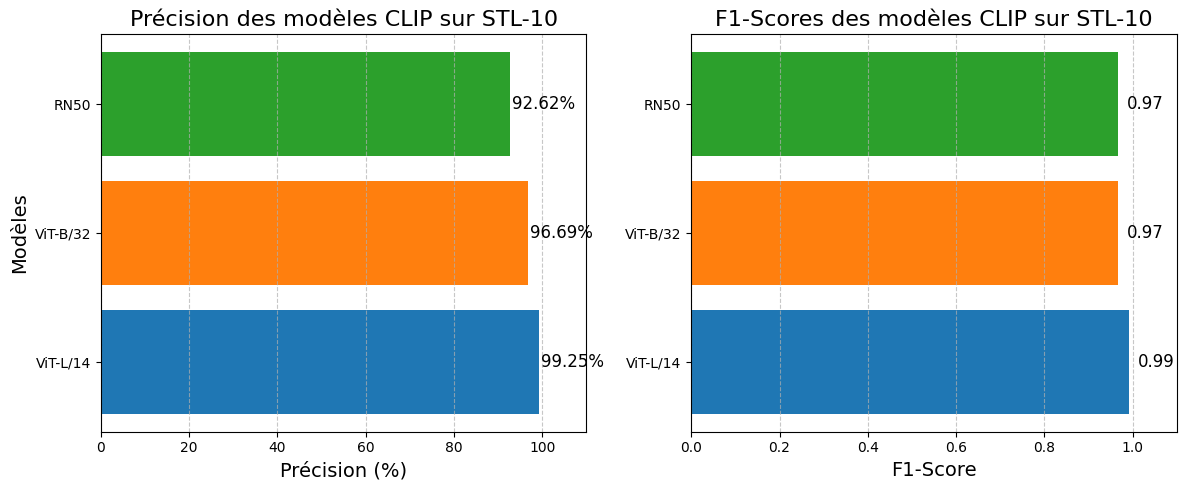

In [9]:
# Résultats des modèles
models = ["ViT-L/14", "ViT-B/32", "RN50"]
accuracies = [avg_precisionVIT14*100, avg_precisionVIT32*100, avg_precisionRN50*100]
f1_scores =[avg_f1VIT14, avg_f1VIT32, avg_f1VIT32]
# Création du graphique à barres horizontales
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graphique des précisions
axes[0].barh(models, accuracies, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[0].set_xlabel("Précision (%)", fontsize=14)
axes[0].set_ylabel("Modèles", fontsize=14)
axes[0].set_title("Précision des modèles CLIP sur STL-10", fontsize=16)
axes[0].set_xlim(0, 110)  
for i, acc in enumerate(accuracies):
    axes[0].text(acc + 0.5, i, f"{acc:.2f}%", va='center', fontsize=12)
axes[0].grid(axis="x", linestyle="--", alpha=0.7)

# Graphique des F1-scores
axes[1].barh(models, f1_scores, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[1].set_xlabel("F1-Score", fontsize=14)
axes[1].set_title("F1-Scores des modèles CLIP sur STL-10", fontsize=16)
axes[1].set_xlim(0, 1.1)  
for i, f1 in enumerate(f1_scores):
    axes[1].text(f1 + 0.02, i, f"{f1:.2f}", va='center', fontsize=12)
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

# Ajustement des espacements
plt.tight_layout()
plt.show()

,Classe,Précision VIT-L/14,Rappel VIT-L/14,F1-score VIT-L/14,Précision VIT-B/32,Rappel VIT-B/32,F1-score VIT-B/32,Précision RN50,Rappel RN50,F1-score RN50
0,avion,1.000000,1.00000,1.000000,1.000000,0.96750,0.983482,0.993557,0.96375,0.978426
1,oiseau,0.993789,1.00000,0.996885,0.971917,0.99500,0.983323,0.916182,0.98375,0.948764
2,voiture,0.993647,0.97750,0.985507,0.987229,0.96625,0.976627,0.979408,0.95125,0.965124
3,chat,0.992376,0.97625,0.984247,0.976257,0.87375,0.922164,0.893499,0.80750,0.848326
4,cerf,0.980344,0.99750,0.988848,0.904268,0.98000,0.940612,0.800208,0.96125,0.873367
5,chien,0.996222,0.98875,0.992472,0.952677,0.95625,0.954460,0.889175,0.86250,0.875634
6,cheval,0.996255,0.99750,0.996877,0.972772,0.98250,0.977612,0.915877,0.96625,0.940389
7,singe,0.998747,0.99625,0.997497,0.971939,0.95250,0.962121,0.974359,0.76000,0.853932
8,bateau,0.997506,1.00000,0.998752,0.969660,0.99875,0.983990,0.946619,0.99750,0.971394
9,camion,0.976601,0.99125,0.983871,0.962287,0.98875,0.975339,0.953488,0.97375,0.963513


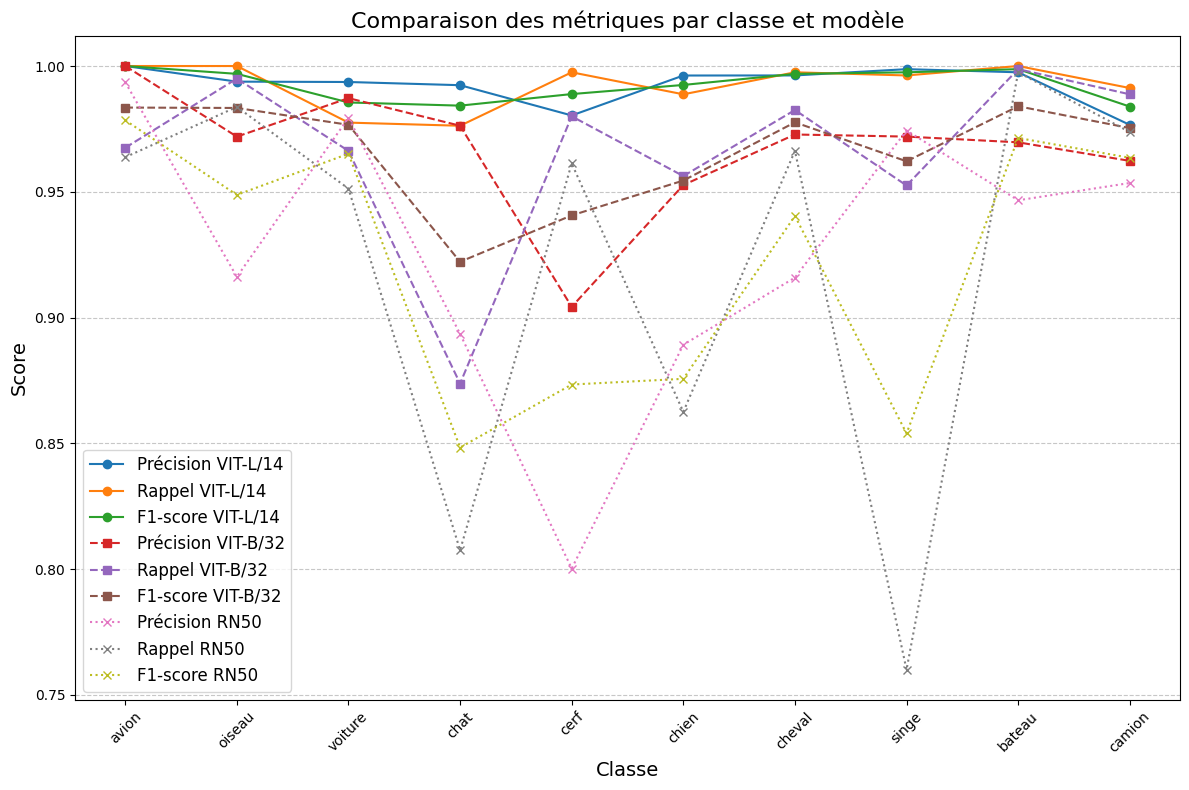

In [10]:
classes = ["avion", "oiseau", "voiture", "chat", "cerf", "chien", "cheval", "singe", "bateau", "camion"]
# Création d'un DataFrame
df = pd.DataFrame({
    "Classe": classes,
    "Précision VIT-L/14": precisionVIT14,
    "Rappel VIT-L/14": recallVIT14,
    "F1-score VIT-L/14": f1_scoreVIT14,
    "Précision VIT-B/32": precisionVIT32,
    "Rappel VIT-B/32": recallVIT32,
    "F1-score VIT-B/32": f1_scoreVIT32,
    "Précision RN50": precisionRN50,
    "Rappel RN50": recallRN50,
    "F1-score RN50": f1_scoreRN50,
})

# Afficher le DataFrame
display(df)

# Graphique détaillé pour chaque classe
df_plot = df.set_index("Classe")

# Création du graphique pour Précision, Rappel et F1-score par modèle
plt.figure(figsize=(12, 8))
for col in ["Précision VIT-L/14", "Rappel VIT-L/14", "F1-score VIT-L/14"]:
    plt.plot(df["Classe"], df[col], marker='o', label=col)

for col in ["Précision VIT-B/32", "Rappel VIT-B/32", "F1-score VIT-B/32"]:
    plt.plot(df["Classe"], df[col], marker='s', linestyle='--', label=col)

for col in ["Précision RN50", "Rappel RN50", "F1-score RN50"]:
    plt.plot(df["Classe"], df[col], marker='x', linestyle=':', label=col)

plt.title("Comparaison des métriques par classe et modèle", fontsize=16)
plt.xlabel("Classe", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12, loc="best")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Test de CLIP sur LC25000


In [13]:
# Définir le chemin vers le dataset
data_dir = "./LC25000"  

# Définir les transformations pour les images
transform = Compose([
    Resize((224, 224)), 
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 
])

# Charger le dataset
dataset = ImageFolder(
    root=data_dir,
    transform=transform
)

# Créer un DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Vérifier les classes
print(f"Classes disponibles : {dataset.classes}")
print(f"Nombre total d'images : {len(dataset)}")

Classes disponibles : ['colon_image_sets', 'lung_image_sets']
Nombre total d'images : 25000


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

# Définir les descriptions textuelles
prompts = [
    "This is an image of colon adenocarcinoma.",
    "This is an image of benign colon tissue.",
    "This is an image of lung adenocarcinoma.",
    "This is an image of benign lung tissue.",
    "This is an image of lung squamous carcinoma."
]

# Tokenizer CLIP
text_inputs = clip.tokenize(prompts).cuda()

In [16]:
# Variables pour stocker les résultats
all_preds = []
all_labels = []

# Évaluation
model.eval()
with torch.no_grad():
    for images, labels in dataloader:
        # Envoyer les images sur le GPU (ou CPU)
        images = images.to(device)
        
        # Calculer les logits entre les images et les textes
        logits_per_image, _ = model(images, text_inputs)
        probs = logits_per_image.softmax(dim=-1) 
        preds = probs.argmax(dim=-1).cpu().numpy() 
        
        # Stocker les prédictions et les labels réels
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Vérification des prédictions et labels
print(f"Exemple de prédictions : {all_preds[:10]}")
print(f"Exemple de labels réels : {all_labels[:10]}")

# Générer un rapport de classification
labels = list(range(len(dataset.classes)))  
report = classification_report(
    all_labels, all_preds, target_names=dataset.classes, labels=labels, zero_division=0
)
print("Rapport de classification :\n", report)

Exemple de prédictions : [np.int64(1), np.int64(2), np.int64(4), np.int64(2), np.int64(3), np.int64(0), np.int64(4), np.int64(4), np.int64(1), np.int64(2)]
Exemple de labels réels : [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Rapport de classification :
                   precision    recall  f1-score   support

colon_image_sets       0.79      0.44      0.57     10000
 lung_image_sets       0.07      0.02      0.03     15000

       micro avg       0.49      0.19      0.27     25000
       macro avg       0.43      0.23      0.30     25000
    weighted avg       0.36      0.19      0.25     25000



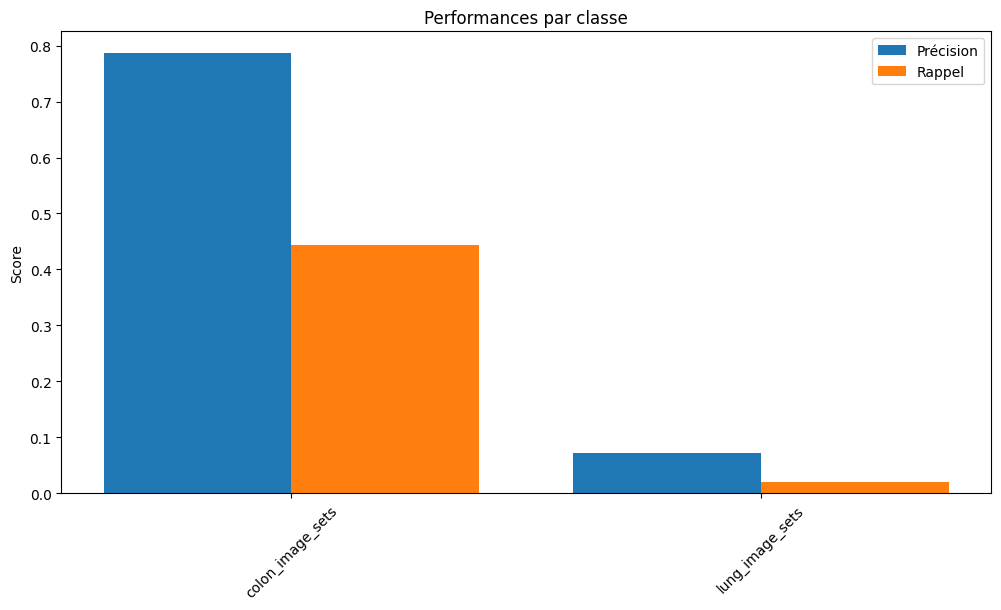

In [17]:
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, labels=range(len(dataset.classes)), zero_division=0
)

# Visualisation des métriques par classe
x = np.arange(len(dataset.classes))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, precision, 0.4, label="Précision")
plt.bar(x + 0.2, recall, 0.4, label="Rappel")
plt.xticks(x, dataset.classes, rotation=45)
plt.ylabel("Score")
plt.title("Performances par classe")
plt.legend()
plt.show()

### Test sur lc25000 redim en 48X48


In [ ]:
# Définir le chemin vers le dataset
data_dir = "./LC25000"  # Remplacez par le chemin exact

# Définir les transformations pour les images
transform = Compose([
    Resize((224, 224)),  
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  
])

# Charger le dataset
dataset = ImageFolder(
    root=data_dir,
    transform=transform
)

# Créer un DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Vérifier les classes
print(f"Classes disponibles : {dataset.classes}")
print(f"Nombre total d'images : {len(dataset)}")

Classes disponibles : ['colon_image_sets', 'lung_image_sets']
Nombre total d'images : 25000


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

# Définir les descriptions textuelles
prompts = [
    "This is an image of colon adenocarcinoma.",
    "This is an image of benign colon tissue.",
    "This is an image of lung adenocarcinoma.",
    "This is an image of benign lung tissue.",
    "This is an image of lung squamous carcinoma."
]

# Tokenizer CLIP
text_inputs = clip.tokenize(prompts).cuda()

In [8]:
# Variables pour stocker les résultats
all_preds = []
all_labels = []

# Évaluation
model.eval()
with torch.no_grad():
    for images, labels in dataloader:
        # Envoyer les images sur le GPU (ou CPU)
        images = images.to(device)
        
        # Calculer les logits entre les images et les textes
        logits_per_image, _ = model(images, text_inputs)
        probs = logits_per_image.softmax(dim=-1)  
        preds = probs.argmax(dim=-1).cpu().numpy() 
        
        # Stocker les prédictions et les labels réels
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Vérification des prédictions et labels
print(f"Exemple de prédictions : {all_preds[:10]}")
print(f"Exemple de labels réels : {all_labels[:10]}")

# Générer un rapport de classification
labels = list(range(len(dataset.classes)))  # Générer des indices pour toutes les classes
report = classification_report(
    all_labels, all_preds, target_names=dataset.classes, labels=labels, zero_division=0
)
print("Rapport de classification :\n", report)

Exemple de prédictions : [np.int64(4), np.int64(4), np.int64(0), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(0), np.int64(4)]
Exemple de labels réels : [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Rapport de classification :
                   precision    recall  f1-score   support

colon_image_sets       0.37      0.29      0.33     10000
 lung_image_sets       0.08      0.00      0.00     15000

       micro avg       0.36      0.12      0.18     25000
       macro avg       0.22      0.15      0.16     25000
    weighted avg       0.19      0.12      0.13     25000



Files already downloaded and verified


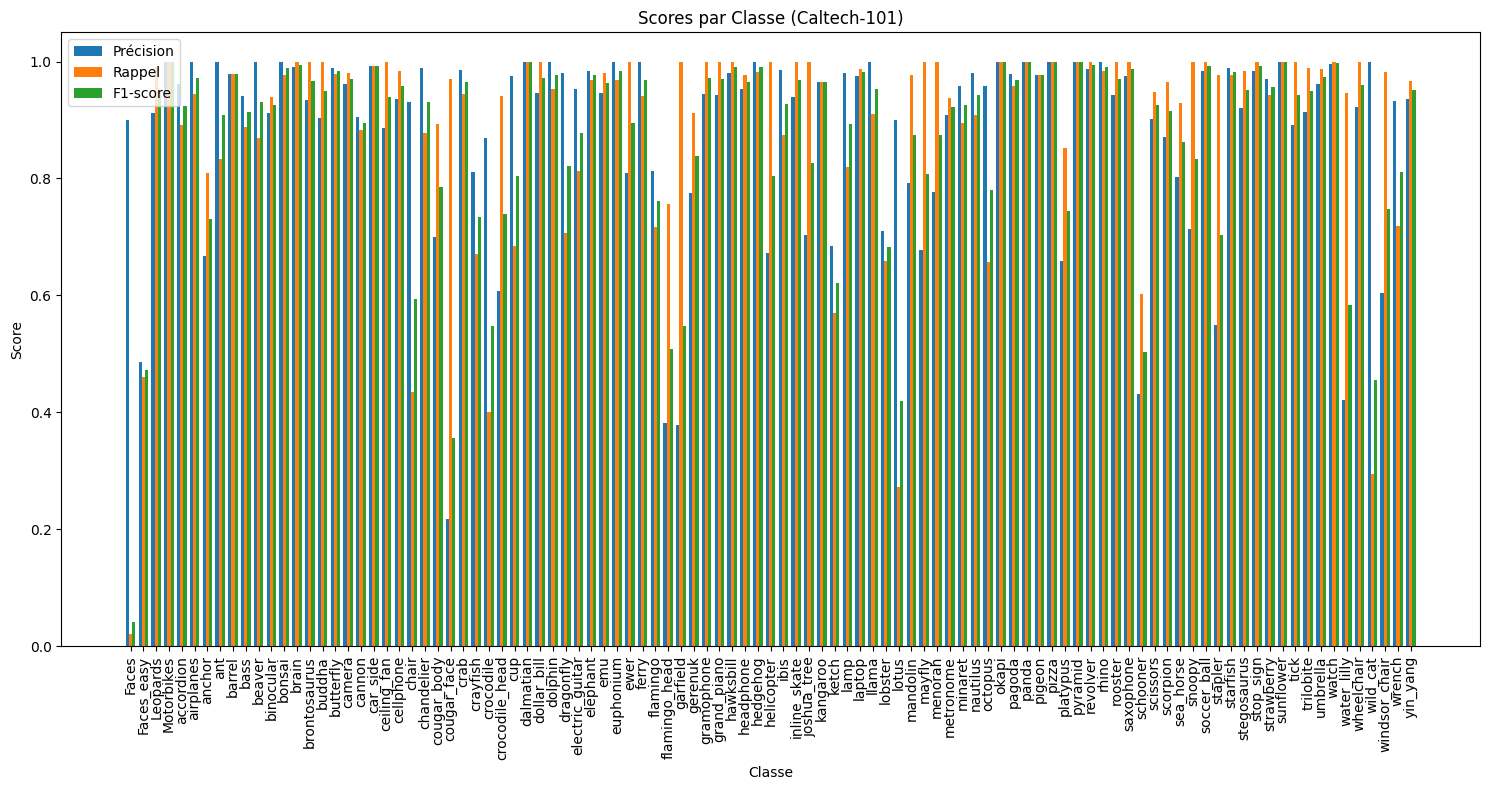

In [22]:
import torch
import clip
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
clip_model_name = "ViT-B/16"  # Changez par "ViT-L/14" pour des performances accrues

# Charger le modèle CLIP
model, preprocess = clip.load(clip_model_name, device=device)
model.eval()

# Préparation des transformations pour Caltech-101
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convertir en RGB
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

# Charger le dataset Caltech-101 (Validation seulement ici)
data_root = "./caltech101"
test_dataset = datasets.Caltech101(root=data_root, download=True, transform=transform, target_type="category")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Préparer les descriptions textuelles des classes
class_labels = test_dataset.categories
text_inputs = clip.tokenize([f"This is a photo of a {label}" for label in class_labels]).to(device)

# Évaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        # Logits image-texte
        logits_per_image = model(images, text_inputs)[0]
        probs = logits_per_image.softmax(dim=-1)
        preds = probs.argmax(dim=-1).cpu().numpy()

        # Stocker les prédictions et les labels
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Générer un rapport de classification
report = classification_report(all_labels, all_preds, target_names=class_labels, output_dict=True, zero_division=0)

# Extraire les scores correctement
precision_scores = [report[label]["precision"] for label in report if label in class_labels]
recall_scores = [report[label]["recall"] for label in report if label in class_labels]
f1_scores = [report[label]["f1-score"] for label in report if label in class_labels]

# Affichage des métriques
x = np.arange(len(class_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(x - width, precision_scores, width, label="Précision")
ax.bar(x, recall_scores, width, label="Rappel")
ax.bar(x + width, f1_scores, width, label="F1-score")

# Configuration des axes et légendes
ax.set_xlabel("Classe")
ax.set_ylabel("Score")
ax.set_title("Scores par Classe (Caltech-101)")
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()
